In [1]:
from faker import Faker
import random
import sqlite3

In [2]:
situacao_civil = ['Solteiro(a)', 'Casado(a)', 'Divorsiado(a)']
fake = Faker('pt_BR')
Faker.seed(0)

cpf = fake.cpf()
nome_completo = fake.name()
emprego_atual = fake.job()
data_nascimento = fake.date_of_birth(minimum_age = 18, maximum_age = 65)
situacao_civil = random.choice(situacao_civil)
endereco = fake.address()
cliente_especial = random.choices([True, False], weights=[0.05, 0.95])[0]


print(cpf)
print(nome_completo)
print(emprego_atual)
print(data_nascimento)
print(situacao_civil)
print(endereco)
print(cliente_especial)

690.243.518-98
Sr. Thiago Carvalho
Escoteiro
1967-12-04
Solteiro(a)
Setor Juan das Neves, 2
São Luiz
78156-593 Macedo de Moreira / GO
False


In [3]:
def gerar_dados_sinteticos(n):

    fake = Faker('pt_BR')

    cpf = fake.cpf()
    nome_completo = fake.name()
    emprego_atual = fake.job()
    data_nascimento = fake.date_of_birth(minimum_age = 18, maximum_age = 65)
    situacao_civil = random.choice(['Solteiro(a)', 'Casado(a)', 'Divorsiado(a)'])
    endereco = fake.address()
    cliente_especial = str(random.choices([1, 0], weights=[0.05, 0.95])[0])

    dados = (cpf, nome_completo, emprego_atual, data_nascimento, situacao_civil, endereco, cliente_especial)
    return dados
gerar_dados_sinteticos(0)

('089.753.621-59',
 'Sr. Luan Santos',
 'Atendente',
 datetime.date(1971, 5, 7),
 'Divorsiado(a)',
 'Setor Machado, 2\nLagoinha Leblon\n14841-858 Pereira / PI',
 '0')

In [4]:
try:
    conn = sqlite3.connect('database.db')
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS "clientes"(
            "id" INTEGER NOT NULL PRIMARY KEY AUTOINCREMENT,
            "cpf" TEXT NOT NULL UNIQUE,
            "nome_completo" TEXT NOT NULL,
            "emprego_atual" TEXT NOT NULL,
            "data_nascimento" DATE NOT NULL,
            "situacao_civil" TEXT NOT NULL,
            "endereco" TEXT NOT NULL,
            "cliente_especial" INTEGER NOT NULL CHECK (cliente_especial IN (0, 1))
    );
    """)

    clientes = []
    for i in range(5000):
        novo_cliente = gerar_dados_sinteticos(i)
        while True:
            try:
                cursor.execute('''INSERT INTO clientes (cpf, nome_completo, emprego_atual, data_nascimento, situacao_civil, endereco, cliente_especial) 
                               VALUES (?, ?, ?, ?, ?, ?, ?)''', novo_cliente)
                conn.commit()
                clientes.append(novo_cliente)
                break
            except sqlite3.IntegrityError:  # Captura a exceção de violação de restrição UNIQUE
                novo_cliente = gerar_dados_sinteticos(i)

except Exception as exception:
    if cursor:
        conn.rollback()
    raise exception
    
finally:
    if cursor:
        conn.close()

# PREPARAÇÃO DOS DADOS

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline




In [2]:
try:
    conn = sqlite3.connect('database.db')
    df = pd.read_sql_query("SELECT * FROM clientes",conn)
except Exception as exception:
    if conn:
        conn.close()
    raise exception
finally:
    if conn:
        conn.close()

df.head()

,id,cpf,nome_completo,emprego_atual,data_nascimento,situacao_civil,endereco,cliente_especial
0,1,576.182.430-26,Pedro Sousa,Governador,1973-02-19,Casado(a),Via Arthur Miguel Vargas\nVila Jardim São José...,0
1,2,894.270.316-03,João Felipe Siqueira,Figurinista,1991-04-29,Casado(a),"Fazenda de Pimenta, 39\nAlta Tensão 1ª Seção\n...",0
2,3,476.981.053-93,Letícia Cassiano,Designer de produto ou desenhista industrial,1983-10-23,Solteiro(a),"Via de Lima, 2\nSão Vicente\n23841-756 Pires d...",0
3,4,835.617.024-90,Sr. Pedro Miguel Nunes,Operador de telemarketing,1997-07-15,Casado(a),"Morro de Ferreira, 67\nSão Bernardo\n35532640 ...",0
4,5,940.532.861-15,Vinicius Pinto,Aviador,2006-05-26,Divorsiado(a),"Viela Maria Luísa Pinto, 73\nMinas Brasil\n110...",0


In [3]:
def extrair_endereco(endereco):
    partes = endereco.split('\n')
    
    # Se houver pelo menos três partes (rua, bairro e cidade/estado)
    if len(partes) >= 3:
        rua_numero = partes[0].split(',')
        if len(rua_numero) == 2:
            rua = rua_numero[0].strip()
        else:
            rua = partes[0].strip()
            
        
        bairro = partes[1].strip()
        cidade_cep = partes[2].split(' ')
        cep = cidade_cep[0] 
        cidade = ' '.join(cidade_cep[1:-2])
        estado = cidade_cep[-1]
        
        return rua, bairro, cidade, estado, cep
    else:
        return None, None, None, None, None

In [4]:
endereco = df['endereco']
ruas, bairros, cidades, estados, ceps = [], [], [], [], []

for i in range(len(endereco)):
    rua, bairro, cidade, estado, cep = extrair_endereco(endereco[i])
    ruas.append(rua)
    bairros.append(bairro)
    cidades.append(cidade)
    estados.append(estado)
    ceps.append(cep)


df['rua'] = ruas
df['bairro'] = bairros
df['cidade'] = cidades
df['estado'] = estados
df['CEP'] = ceps

df.head()

,id,cpf,nome_completo,emprego_atual,data_nascimento,situacao_civil,endereco,cliente_especial,rua,bairro,cidade,estado,CEP
0,1,576.182.430-26,Pedro Sousa,Governador,1973-02-19,Casado(a),Via Arthur Miguel Vargas\nVila Jardim São José...,0,Via Arthur Miguel Vargas,Vila Jardim São José,Pereira,AP,45154736
1,2,894.270.316-03,João Felipe Siqueira,Figurinista,1991-04-29,Casado(a),"Fazenda de Pimenta, 39\nAlta Tensão 1ª Seção\n...",0,Fazenda de Pimenta,Alta Tensão 1ª Seção,da Conceição da Prata,SC,84161-002
2,3,476.981.053-93,Letícia Cassiano,Designer de produto ou desenhista industrial,1983-10-23,Solteiro(a),"Via de Lima, 2\nSão Vicente\n23841-756 Pires d...",0,Via de Lima,São Vicente,Pires de Minas,SC,23841-756
3,4,835.617.024-90,Sr. Pedro Miguel Nunes,Operador de telemarketing,1997-07-15,Casado(a),"Morro de Ferreira, 67\nSão Bernardo\n35532640 ...",0,Morro de Ferreira,São Bernardo,Fogaça do Oeste,PI,35532640
4,5,940.532.861-15,Vinicius Pinto,Aviador,2006-05-26,Divorsiado(a),"Viela Maria Luísa Pinto, 73\nMinas Brasil\n110...",0,Viela Maria Luísa Pinto,Minas Brasil,Pires,PB,11031656


In [5]:
df['data_nascimento'] = pd.to_datetime(df['data_nascimento'])
hoje = datetime.date.today()
df['idade'] = df['data_nascimento'].apply(lambda x: hoje.year - x.year - ((hoje.month, hoje.day) < (x.month, x.day)))
df.head()


,id,cpf,nome_completo,emprego_atual,data_nascimento,situacao_civil,endereco,cliente_especial,rua,bairro,cidade,estado,CEP,idade
0,1,576.182.430-26,Pedro Sousa,Governador,1973-02-19,Casado(a),Via Arthur Miguel Vargas\nVila Jardim São José...,0,Via Arthur Miguel Vargas,Vila Jardim São José,Pereira,AP,45154736,51
1,2,894.270.316-03,João Felipe Siqueira,Figurinista,1991-04-29,Casado(a),"Fazenda de Pimenta, 39\nAlta Tensão 1ª Seção\n...",0,Fazenda de Pimenta,Alta Tensão 1ª Seção,da Conceição da Prata,SC,84161-002,33
2,3,476.981.053-93,Letícia Cassiano,Designer de produto ou desenhista industrial,1983-10-23,Solteiro(a),"Via de Lima, 2\nSão Vicente\n23841-756 Pires d...",0,Via de Lima,São Vicente,Pires de Minas,SC,23841-756,40
3,4,835.617.024-90,Sr. Pedro Miguel Nunes,Operador de telemarketing,1997-07-15,Casado(a),"Morro de Ferreira, 67\nSão Bernardo\n35532640 ...",0,Morro de Ferreira,São Bernardo,Fogaça do Oeste,PI,35532640,26
4,5,940.532.861-15,Vinicius Pinto,Aviador,2006-05-26,Divorsiado(a),"Viela Maria Luísa Pinto, 73\nMinas Brasil\n110...",0,Viela Maria Luísa Pinto,Minas Brasil,Pires,PB,11031656,18


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5000 non-null   int64         
 1   cpf               5000 non-null   object        
 2   nome_completo     5000 non-null   object        
 3   emprego_atual     5000 non-null   object        
 4   data_nascimento   5000 non-null   datetime64[ns]
 5   situacao_civil    5000 non-null   object        
 6   endereco          5000 non-null   object        
 7   cliente_especial  5000 non-null   int64         
 8   rua               5000 non-null   object        
 9   bairro            5000 non-null   object        
 10  cidade            5000 non-null   object        
 11  estado            5000 non-null   object        
 12  CEP               5000 non-null   object        
 13  idade             5000 non-null   int64         
dtypes: datetime64[ns](1), in

In [7]:
df.describe()

,id,data_nascimento,cliente_especial,idade
count,5000.000000,5000,5000.000000,5000.000000
mean,2500.500000,1982-02-21 02:33:30.240000,0.047800,41.772400
min,1.000000,1958-05-29 00:00:00,0.000000,18.000000
25%,1250.750000,1970-01-23 18:00:00,0.000000,30.000000
50%,2500.500000,1981-09-28 00:00:00,0.000000,42.000000
75%,3750.250000,1994-02-14 12:00:00,0.000000,54.000000
max,5000.000000,2006-05-26 00:00:00,1.000000,66.000000
std,1443.520003,NaN,0.213364,13.819189


In [8]:
df.select_dtypes(include = 'object').describe()

,cpf,nome_completo,emprego_atual,situacao_civil,endereco,rua,bairro,cidade,estado,CEP
count,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,5000,4709,749,3,5000,4443,482,1968,27,5000
top,576.182.430-26,Eduardo Moraes,Artista plástico,Casado(a),Via Arthur Miguel Vargas\nVila Jardim São José...,Fazenda Macedo,Alípio De Melo,Pereira,CE,45154736
freq,1,3,17,1696,1,4,21,37,210,1


In [9]:
df['cliente_especial'].value_counts()


cliente_especial
0    4761
1     239
Name: count, dtype: int64

In [4]:
df_transformado = pd.read_csv('../../data/clientes.csv')
df_transformado = df_transformado[['emprego_atual', 'idade', 'situacao_civil', 'bairro', 'cidade', 'estado', 'cliente_especial']]
df_transformado.head()

,emprego_atual,idade,situacao_civil,bairro,cidade,estado,cliente_especial
0,Governador,51,Casado(a),Vila Jardim São José,Pereira,AP,0
1,Figurinista,33,Casado(a),Alta Tensão 1ª Seção,da Conceição da Prata,SC,0
2,Designer de produto ou desenhista industrial,40,Solteiro(a),São Vicente,Pires de Minas,SC,0
3,Operador de telemarketing,26,Casado(a),São Bernardo,Fogaça do Oeste,PI,0
4,Aviador,18,Divorsiado(a),Minas Brasil,Pires,PB,0


# Regressao Logistica 

In [5]:
X = df_transformado.drop(columns = 'cliente_especial')
y = df_transformado['cliente_especial']

one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore')
X_enc = one_hot_encoder.fit_transform(X.drop(columns =['idade']))

smote_bal = SMOTE(random_state = 42)

X_bal, y_bal = smote_bal.fit_resample(X_enc, y)




In [6]:
pipeline = Pipeline(steps = [
                ('s_scale', StandardScaler(with_mean=False)),
                ('pca', PCA()),
                ('reg_log', LogisticRegression())
            ])

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)


In [7]:
param_grid = {
                'reg_log__C': [0.1, 1, 10],
                'reg_log__solver': ['liblinear', 'saga'],
                'reg_log__max_iter': [500, 1000]
                }
            
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

            
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_)

Melhores hiperparâmetros: {'reg_log__C': 0.1, 'reg_log__max_iter': 500, 'reg_log__solver': 'saga'}
Acurácia: 0.9177795780778558


In [8]:
best_model = grid_search.best_estimator_

modelo = best_model.fit(X_train, y_train)
    

modelo_score = modelo.score(X_test, y_test)
print(modelo_score)

0.9450472523626181


In [9]:
predict = modelo.predict(X_test)
report = classification_report(y_test, predict)
print("classification report", report)

classification report               precision    recall  f1-score   support

           0       1.00      0.89      0.94      1429
           1       0.90      1.00      0.95      1428

    accuracy                           0.95      2857
   macro avg       0.95      0.95      0.94      2857
weighted avg       0.95      0.95      0.94      2857



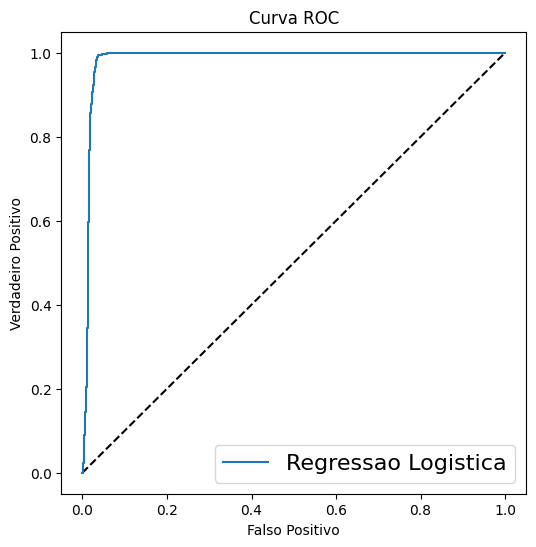

area sob a curva:  0.9860708454130428


In [10]:
y_score = modelo.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_score[:, 1])
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = "Regressao Logistica")
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right", fontsize=16)
plt.show()
print('area sob a curva: ', auc(fpr, tpr))

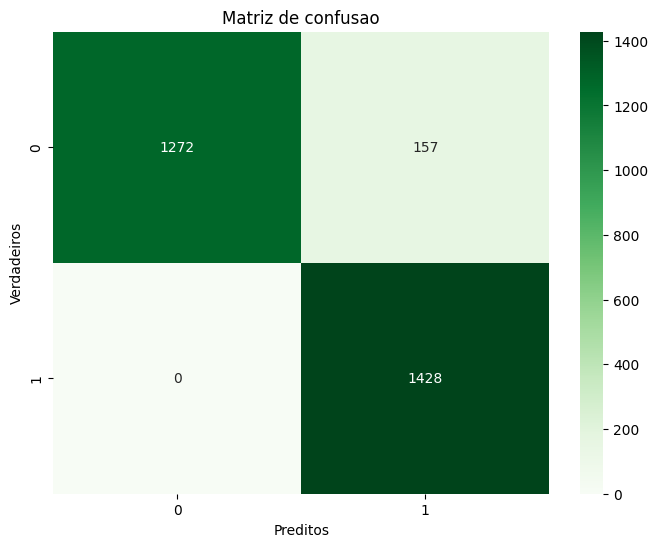

In [11]:
conf_matrix = confusion_matrix(y_test, predict)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Preditos')
plt.ylabel('Verdadeiros')
plt.title('Matriz de confusao')
plt.show()

# SVM

In [18]:
from sklearn.svm import SVC

In [20]:
X = df_transformado.drop(columns = 'cliente_especial')
y = df_transformado['cliente_especial']

one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore')
X_enc = one_hot_encoder.fit_transform(X.drop(columns =['idade']))

smote_bal = SMOTE(random_state = 42)

X_bal, y_bal = smote_bal.fit_resample(X_enc, y)

In [21]:
pipeline = Pipeline(steps = [
                ('s_scaler', StandardScaler(with_mean=False)),
                ('pca', PCA()),
                ('svm', SVC())
            ])

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)

In [22]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale'],
    'svm__kernel': ['linear', 'rbf'] 
}
           
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_bal, y_bal)
           
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Melhores hiperparâmetros: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Acurácia: 0.9522159210249947


In [26]:
modelo = best_model.fit(X_train, y_train)
modelo_score = modelo.score(X_test, y_test)
print(modelo_score)

0.9674483724186209


In [27]:
predict = modelo.predict(X_test)
report = classification_report(y_test, predict)
print("classification report ", report)

classification report                precision    recall  f1-score   support

           0       1.00      0.94      0.97      1429
           1       0.94      1.00      0.97      1428

    accuracy                           0.97      2857
   macro avg       0.97      0.97      0.97      2857
weighted avg       0.97      0.97      0.97      2857



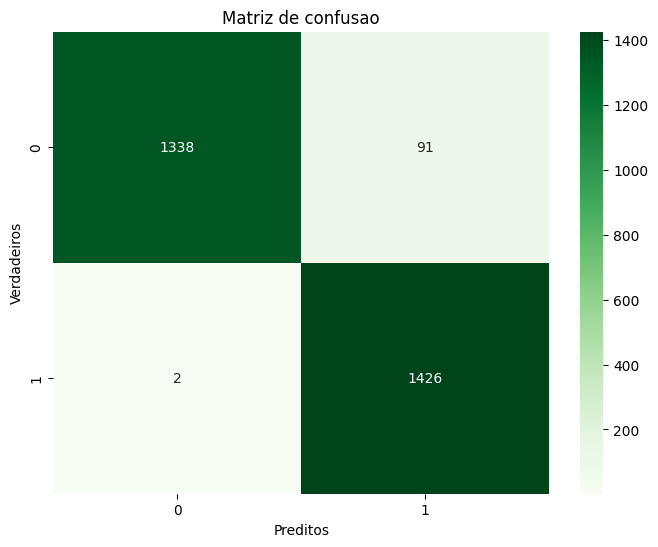

In [29]:
conf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Preditos')
plt.ylabel('Verdadeiros')
plt.title('Matriz de confusao')
plt.show()

# Arvore de Decisao

In [30]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree

In [31]:
X = df_transformado.drop(columns = 'cliente_especial')
y = df_transformado['cliente_especial']

one_hot_encoder = OneHotEncoder(handle_unknown = 'ignore')
X_enc = one_hot_encoder.fit_transform(X.drop(columns =['idade']))

smote_bal = SMOTE(random_state = 42)

X_bal, y_bal = smote_bal.fit_resample(X_enc, y)

In [32]:
pipeline = Pipeline(steps= [
            ('s_scaler', StandardScaler(with_mean=False)),
            ('pca', PCA()),
            ('tree', DecisionTreeClassifier()) 
        ])

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size = 0.30, random_state = 42)

In [33]:
param_grid = {
    'tree__criterion': ['gini'],  
    'tree__max_depth': [None, 10],      
    'tree__min_samples_leaf': [1, 2],  
    'tree__min_samples_split': [2, 5]
}
            
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Acurácia:", grid_search.best_score_) 

Melhores hiperparâmetros: {'tree__criterion': 'gini', 'tree__max_depth': None, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 2}
Acurácia: 0.9335329091132403


In [34]:
best_model = grid_search.best_estimator_

modelo = best_model.fit(X_train, y_train)

In [35]:
modelo_score = modelo.score(X_test, y_test)
print(modelo_score)

0.9852992649632482


In [36]:
predict = modelo.predict(X_test)

print("classification report ", classification_report(y_test, predict))

classification report                precision    recall  f1-score   support

           0       0.99      0.98      0.99      1429
           1       0.98      0.99      0.99      1428

    accuracy                           0.99      2857
   macro avg       0.99      0.99      0.99      2857
weighted avg       0.99      0.99      0.99      2857



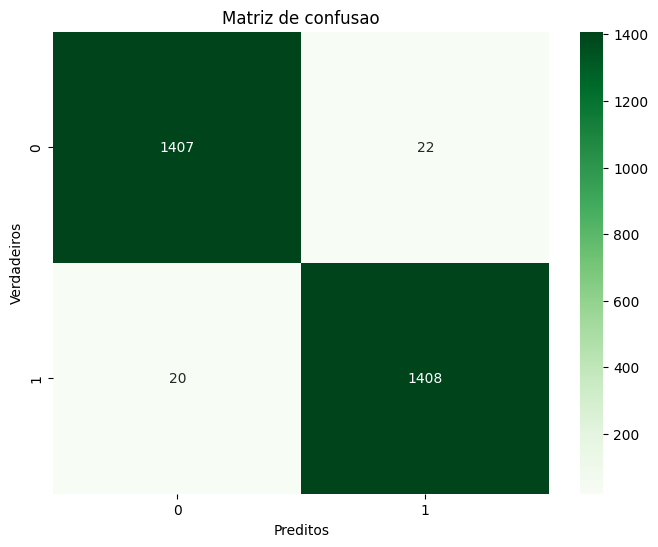

In [37]:
conf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Preditos')
plt.ylabel('Verdadeiros')
plt.title('Matriz de confusao')
plt.show()

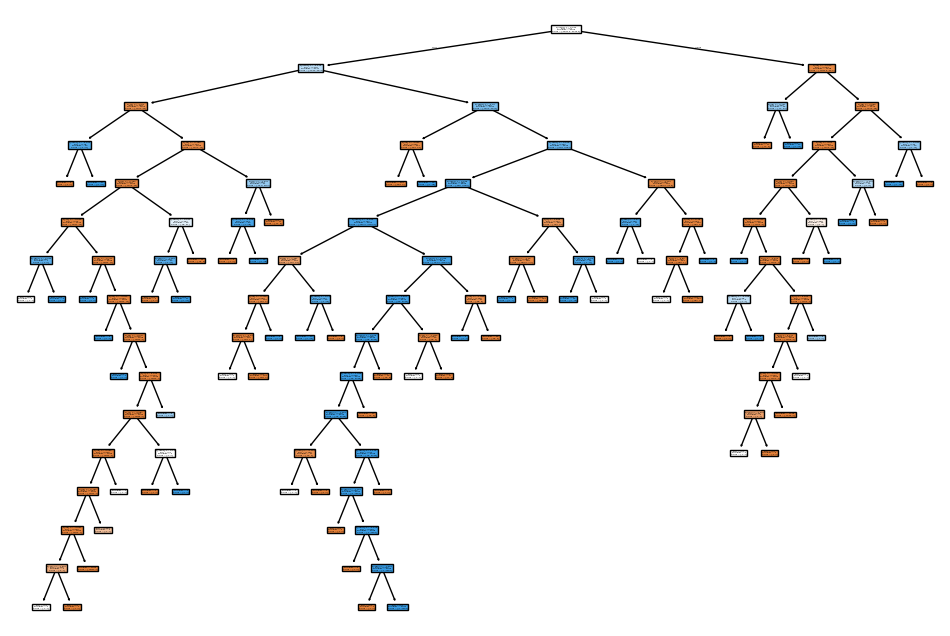

In [39]:
plt.figure(figsize = (12, 8))
decision_tree = best_model.named_steps['tree']
plot_tree(decision_tree, filled = True)
plt.show()
